In [1]:
# Data stuff
import numpy as np
import pandas as pd
import dask.dataframe as dd

# Visual stuff
from IPython.display import display
# Configs 
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Random state seed
rand_state=42

# ML stuff
import sklearn
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import shap

# Dask
from dask.distributed import Client
client = Client()  # start distributed scheduler locally.  Launch dashboard

# Prepa data-set for models

In [2]:
# Import and display data-set
dataset = dd.read_csv('../data_gen/dataset_mean_undersample/*.part')
# Ensure correct types
dataset = dataset.astype(dtype={
    'gender':int,
    'ethnicity_AMERICAN INDIAN/ALASKA NATIVE':int,
    'ethnicity_ASIAN':int,
    'ethnicity_BLACK/AFRICAN AMERICAN':int,
    'ethnicity_HISPANIC/LATINO':int,
    'ethnicity_WHITE':int,
    'insurance_Medicaid':int,
    'insurance_Medicare':int,
    'marital_status_DIVORCED':int,
    'marital_status_MARRIED':int,
    'marital_status_SINGLE':int,
    'marital_status_WIDOWED':int,
    'language_english':int,
    'hospital_expire_flag':int,
})
# Order ints(categorical variables) and floats(number variables)
dataset = dataset[[
 'ethnicity_AMERICAN INDIAN/ALASKA NATIVE',
 'ethnicity_ASIAN',
 'ethnicity_BLACK/AFRICAN AMERICAN',
 'ethnicity_HISPANIC/LATINO',
 'ethnicity_WHITE',
 'insurance_Medicaid',
 'insurance_Medicare',
 'marital_status_DIVORCED',
 'marital_status_MARRIED',
 'marital_status_SINGLE',
 'marital_status_WIDOWED',
 'gender',
 'language_english',
 'hospital_expire_flag',
 'age_at_admission',
 'seq_num',
 'times_prev_admitted',
 'length_of_stay(days)',
 'BMI',
 'Glucose',
 'Potassium',
 'Sodium',
 'Chloride',
 'Bicarbonate',
 'Anion Gap',
 'Creatinine',
 'Urea Nitrogen',
 'Magnesium',
 'Hematocrit',
 'Hemoglobin',
 'Platelet Count',
 'Phosphate',
 'Calcium, Total',
 'White Blood Cells',
 'Red Blood Cells',
 'MCH',
 'RDW',
 'MCV',
 'pH',
 'PTT',
 'PT',
 'H'
]].compute()

In [3]:
# Generate data set withouth categories(all numbers)
Y_no_cat = dataset.hospital_expire_flag.values
X_no_cat = dataset.drop(columns=['hospital_expire_flag']).values

# dataset as is, but target variable dropped(hospital expire flag)
dataset_no_target = dataset.drop(columns=['hospital_expire_flag'])

# Feture names and categorical feature names
feature_names = dataset_no_target.select_dtypes(include='int').columns.values.tolist() + dataset_no_target.select_dtypes(exclude='int').columns.values.tolist() 
cat_feature_names = dataset_no_target.select_dtypes(include='int').columns.values.tolist() 

# Generate data set with categories(int type required)
dataframe_int_list = dataset_no_target.select_dtypes(include='int').values.tolist()
dataframe_no_int_list = dataset_no_target.select_dtypes(exclude='int').values.tolist()
Y = dataset.hospital_expire_flag.values.tolist()
X = []
for i,v in enumerate(dataframe_int_list):
    X = X + [v+dataframe_no_int_list[i]]

# Generate categorical feature indicies
cat_features_indices=list(range(0,len(dataframe_int_list[0])))

# Define functions and variables

In [4]:
# Function that w
def strat_cv_it(classifier, params, uses_cat, param_comb ):
    folds = 3
    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = rand_state)
    
    # Perform fit and scoring
    if uses_cat:
        random_search = RandomizedSearchCV( classifier, return_train_score=True, param_distributions=params ,scoring='roc_auc', n_iter=param_comb, n_jobs=4, cv=skf.split(X, Y),random_state = rand_state, refit=True, verbose=3,  )
        random_search.fit(X, Y)     
    else:
        random_search = RandomizedSearchCV( classifier, return_train_score=True, param_distributions=params ,scoring='roc_auc', n_iter=param_comb, n_jobs=4, cv=skf.split(X_no_cat, Y_no_cat),random_state = rand_state, refit=True, verbose=3)
        random_search.fit(X_no_cat, Y_no_cat)
    
    # Display results and return best model
    display(random_search.best_score_)
    display(random_search.best_params_)
    display(pd.DataFrame(random_search.cv_results_))
    return random_search.best_estimator_

# Models

## Random Forest

In [5]:
RF_classifier =  RandomForestClassifier(class_weight='balanced')
RF_params = {
        'max_depth': (3,4,5,6,7,10,15,20,25),
        'n_estimators': (1,5,10,25,50,100),
        'criterion':['gini','entropy'],
        'max_features': ['auto', 'sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'bootstrap': [False,True],
        'class_weight':[None,'balanced_subsample','balanced']
}
model = strat_cv_it(RF_classifier ,RF_params,False, 50)
explainer = shap.TreeExplainer(model)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.3s finished


0.8298541055483684

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 15,
 'criterion': 'entropy',
 'class_weight': None,
 'bootstrap': False}

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.254319  8.019817e-03         0.011304    9.407182e-04   
1        0.079122  5.235100e-03         0.004654    9.409426e-04   
2        0.065824  2.820467e-03         0.003990    4.052337e-07   
3        0.031582  1.244113e-03         0.003657    1.695046e-03   
4        0.292217  7.052123e-03         0.011968    1.123916e-07   
5        0.568811  1.293549e-02         0.017287    3.291163e-03   
6        0.022938  2.973602e-07         0.002660    4.704713e-04   
7        0.269279  7.328470e-03         0.010638    4.697407e-04   
8        0.257644  1.694765e-03         0.010639    4.706399e-04   
9        0.523599  7.852888e-03         0.014296    4.700779e-04   
10       0.072472  4.700217e-04         0.003657    4.704150e-04   
11       0.743344  6.632770e-03         0.026596    1.694968e-03   
12       0.447136  1.262408e-02         0.018618    4.705837e-04   
13       0.008976  5.150430e-07         0.001994    2.247832e-07   
14       1.054512  9.816698e-03         0.027260    1.243815e-03   
15       0.044215  4.702465e-04         0.003657    4.706398e-04   
16       0.512629  6.147968e-03         0.028922    4.534036e-03   
17       0.018949  8.144908e-04         0.002328    4.699655e-04   
18       0.130650  2.154388e-03         0.007646    9.404930e-04   
19       0.047207  1.243518e-03         0.003989    8.142961e-04   
20       0.485368  5.421919e-03         0.019947    1.628495e-03   
21       0.009308  1.880424e-03         0.002327    4.697407e-04   
22       0.052858  2.443180e-03         0.003325    4.701903e-04   
23       0.049202  5.421636e-03         0.004654    2.350221e-03   
24       0.036569  9.402681e-04         0.002992    8.143935e-04   
25       0.007314  4.698533e-04         0.002327    4.706406e-04   
26       0.047206  1.243518e-03         0.003990    2.247832e-07   
27       0.067818  8.141987e-04         0.004322    4.702464e-04   
28       0.289891  4.694599e-04         0.011969    8.145882e-04   
29       0.070810  2.443278e-03         0.003657    4.702465e-04   
30       0.020612  1.694282e-03         0.002327    4.697409e-04   
31       0.018617  4.703026e-04         0.002660    4.700779e-04   
32       0.745007  8.807824e-03         0.030586    2.049589e-03   
33       0.517283  1.513263e-02         0.019614    1.243773e-03   
34       0.037899  1.410458e-03         0.003324    4.699094e-04   
35       0.084773  5.699836e-03         0.004986    2.973602e-07   
36       0.384305  1.243773e-03         0.014960    1.410515e-03   
37       0.304186  2.820748e-03         0.016955    1.946680e-07   
38       0.081781  5.150430e-07         0.003990    2.973602e-07   
39       0.276593  4.484634e-03         0.007979    1.123916e-07   
40       0.009973  8.140041e-04         0.001662    4.706398e-04   
41       0.024268  4.703590e-04         0.002993    1.123916e-07   
42       0.426858  1.700426e-02         0.012633    9.393128e-04   
43       0.010638  4.700217e-04         0.001995    2.247832e-07   
44       0.422204  2.018371e-02         0.013963    8.143934e-04   
45       0.029920  8.140041e-04         0.003325    4.697409e-04   
46       0.006316  4.699093e-04         0.001662    4.700217e-04   
47       0.248668  1.629348e-02         0.013298    2.049692e-03   
48       0.695140  5.872512e-03         0.019946    8.145881e-04   
49       0.030917  2.442791e-03         0.002659    4.700779e-04   

   param_n_estimators param_min_samples_split param_min_samples_leaf  \
0                  50                      10                      2   
1                  10                      10                      4   
2                  10                       5                      4   
3                   5                       5                      1   
4                  50                      10                      4   
5                  50                       5                      1   
6                   5          

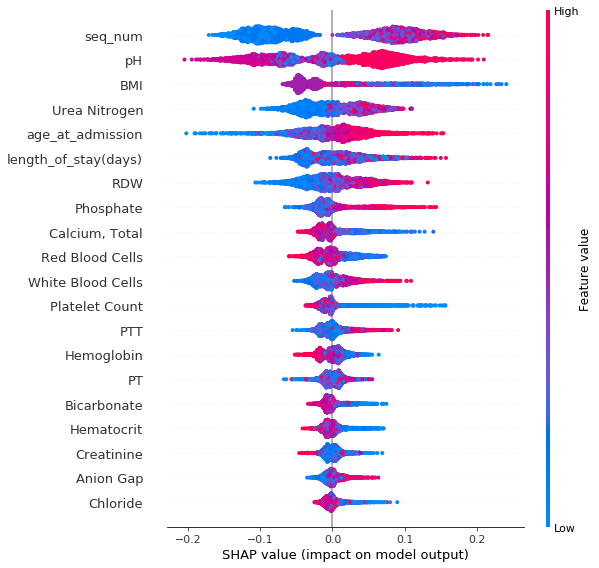

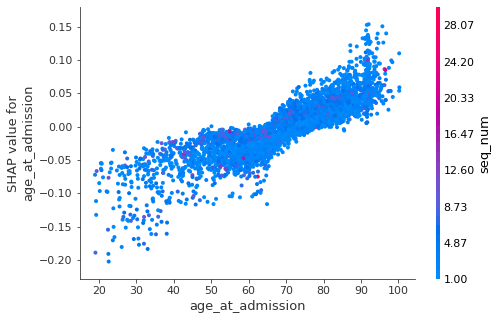

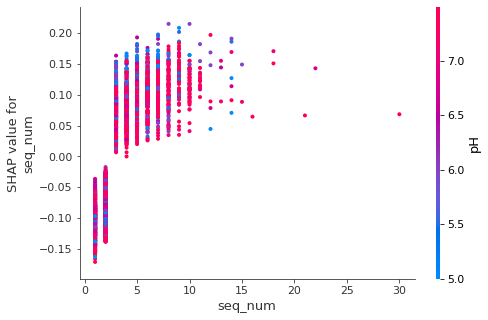

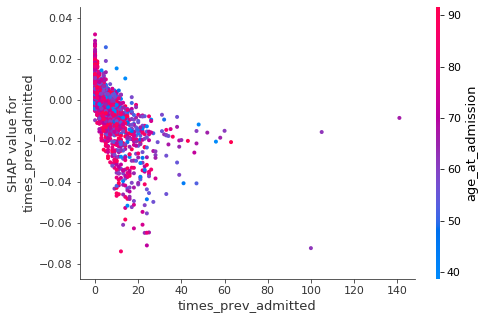

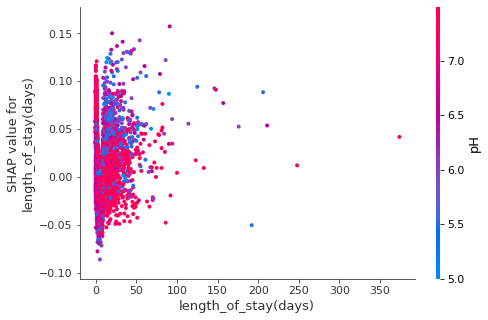

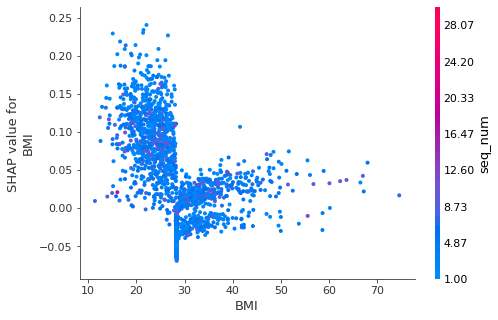

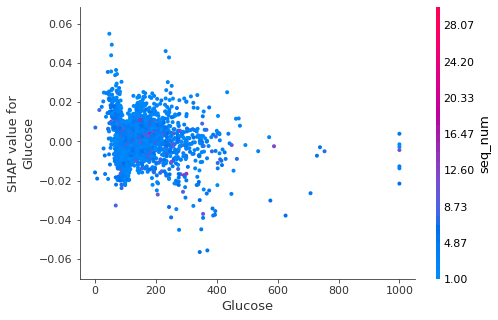

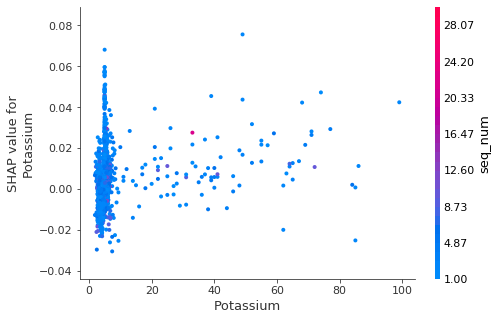

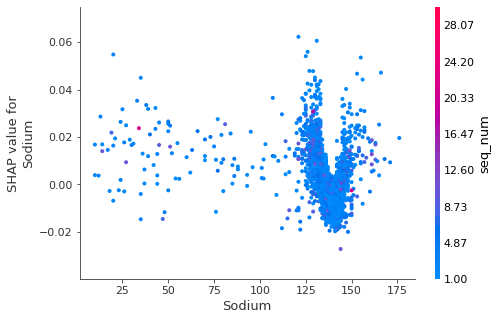

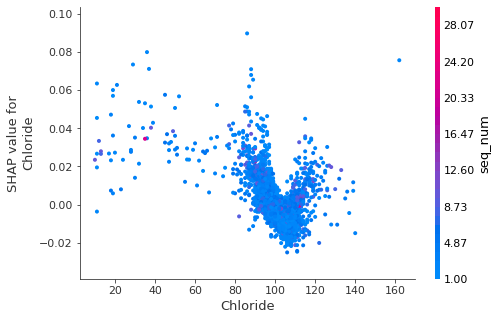

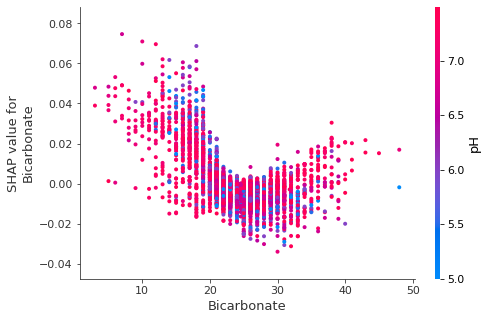

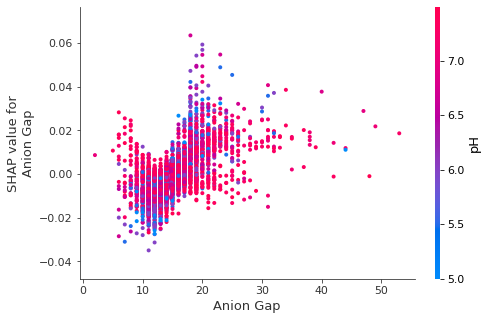

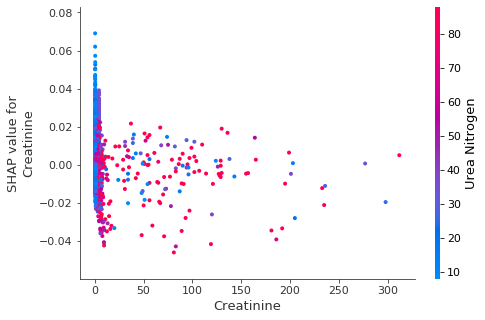

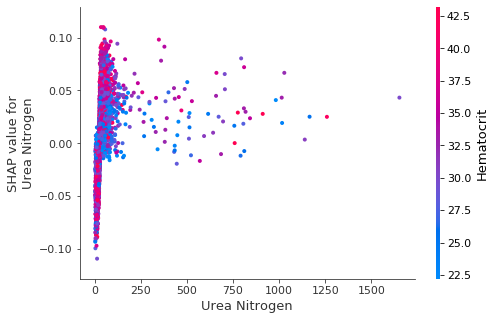

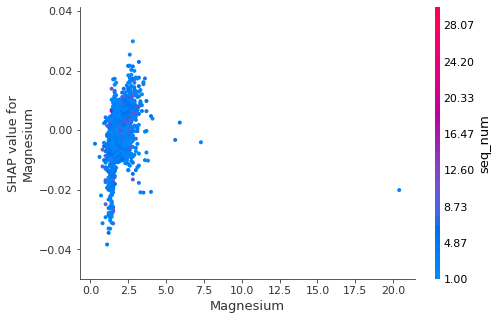

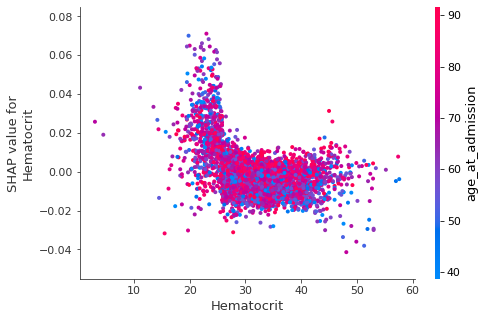

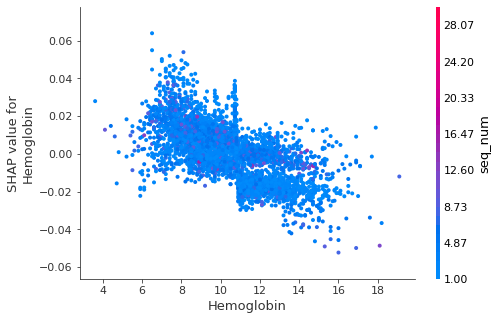

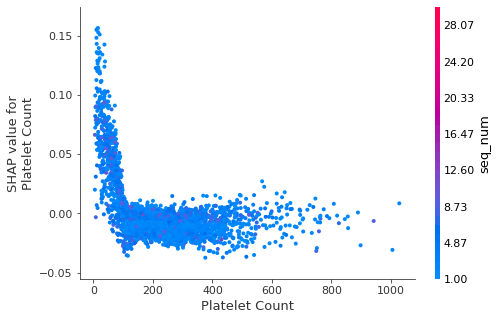

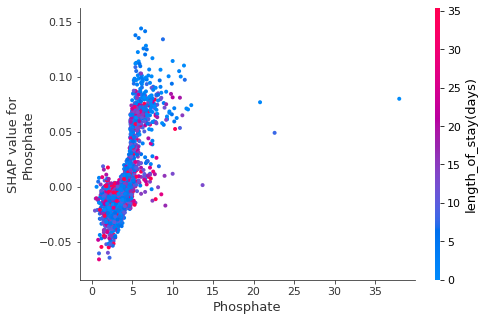

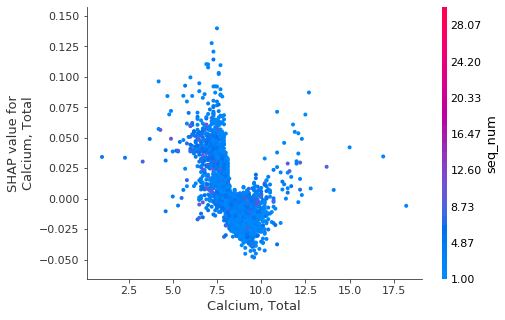

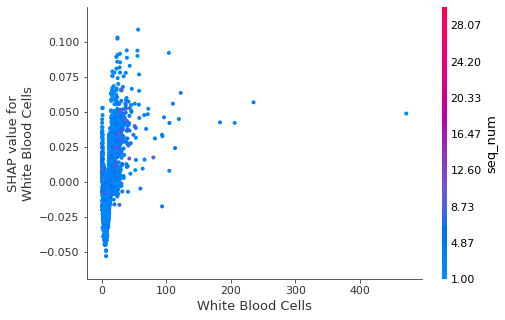

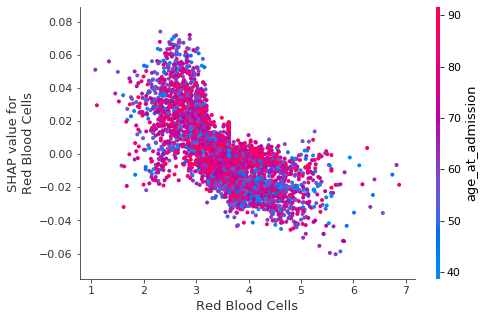

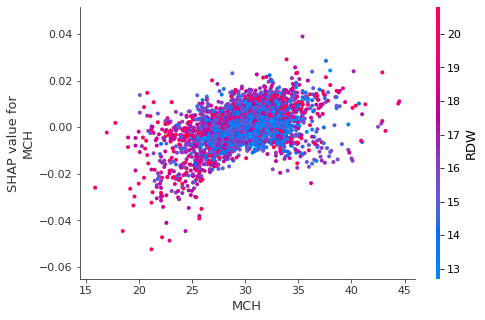

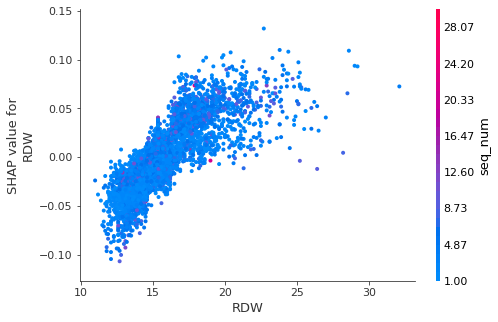

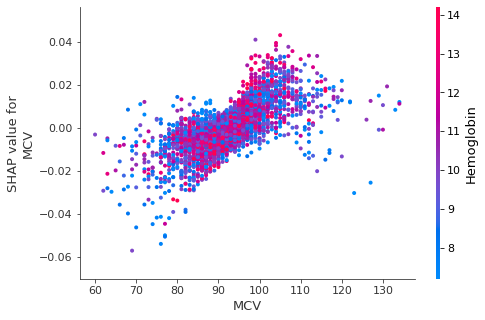

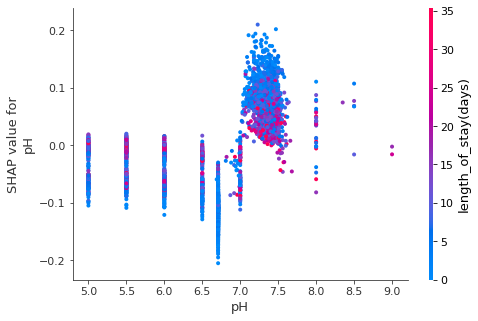

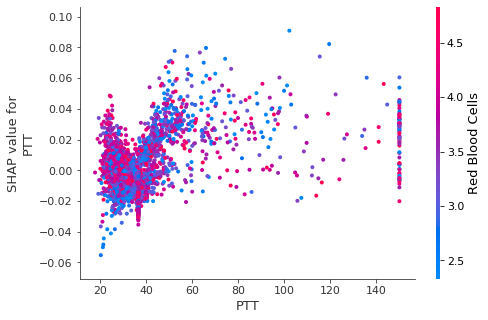

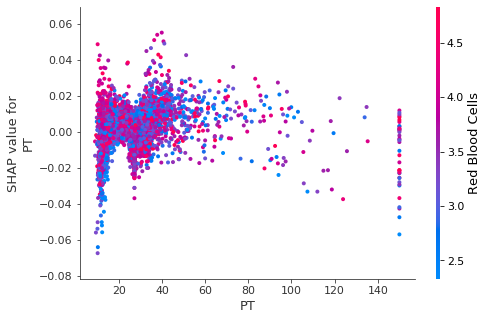

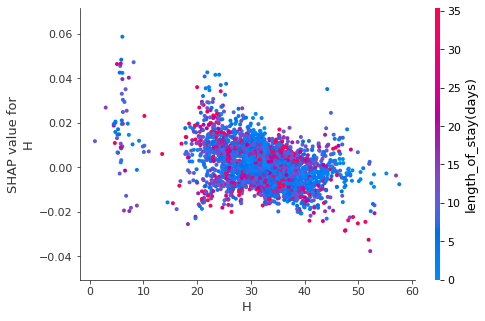

In [6]:
shap_values = explainer.shap_values( X_no_cat)
shap.summary_plot(shap_values[1],X_no_cat ,feature_names=feature_names)
for predictor in feature_names:
    if predictor not in cat_feature_names:
        shap.dependence_plot(predictor, shap_values[1],X_no_cat ,feature_names=feature_names)

## XGBOOST

In [7]:
xgb_classifier = xgb.XGBClassifier(objective = "binary:logistic",random_state=rand_state)
xgb_params = {
        'learning_rate': (0.01, 0.05,0.1),
        'min_child_weight': [3, 5, 10],
        'gamma': [0.5, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': list(range(5,30)),
        'scale_pos_weight':  [0.5,0.75,0.9,1, 1.1, 1.25,1.5]
}
model = strat_cv_it(xgb_classifier ,xgb_params,False,50)
explainer = shap.TreeExplainer(model)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    9.6s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   29.5s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   35.1s finished


0.8376943776006698

{'subsample': 0.8,
 'scale_pos_weight': 1,
 'min_child_weight': 10,
 'max_depth': 22,
 'learning_rate': 0.05,
 'gamma': 5,
 'colsample_bytree': 0.8}

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        1.559163      0.012087         0.014628    2.859908e-03   
1        0.664888      0.102657         0.007979    2.247832e-07   
2        0.945471      0.087162         0.015624    1.694656e-03   
3        0.777919      0.022567         0.008976    1.123916e-07   
4        1.237356      0.011698         0.013297    4.705274e-04   
5        1.252649      0.016225         0.014627    9.398185e-04   
6        0.670540      0.008631         0.013298    4.699657e-04   
7        1.422195      0.010006         0.012300    4.705836e-04   
8        0.738359      0.006581         0.012632    4.697407e-04   
9        0.814488      0.021504         0.011968    8.143936e-04   
10       0.835100      0.011526         0.008643    4.701903e-04   
11       1.037891      0.015023         0.014959    8.141015e-04   
12       1.291878      0.015372         0.013630    4.701341e-04   
13       0.533572      0.001411         0.009641    4.703027e-04   
14       0.582443      0.004309         0.008643    1.695170e-03   
15       0.683837      0.008970         0.011968    1.123916e-07   
16       0.384970      0.003257         0.009974    5.840039e-07   
17       0.876324      0.006632         0.015957    8.141988e-04   
18       1.210762      0.020488         0.009973    2.247832e-07   
19       0.763624      0.004179         0.014627    9.403243e-04   
20       0.897599      0.002936         0.017619    1.695389e-03   
21       0.578453      0.005700         0.008310    4.701341e-04   
22       1.163886      0.022844         0.012300    4.701342e-04   
23       0.521604      0.003257         0.010638    2.350389e-03   
24       0.754648      0.005891         0.010305    4.698531e-04   
25       0.728385      0.006112         0.010638    4.703026e-04   
26       0.848065      0.002617         0.011968    8.145881e-04   
27       0.470741      0.009068         0.011303    4.703026e-04   
28       0.991681      0.019431         0.013962    8.143934e-04   
29       0.819807      0.006464         0.010638    4.705838e-04   
30       1.029246      0.003732         0.015625    4.701903e-04   
31       0.470741      0.004231         0.008311    4.703589e-04   
32       0.860366      0.009817         0.010637    4.700217e-04   
33       0.828119      0.011116         0.016621    1.695482e-03   
34       0.609038      0.000941         0.011635    4.696851e-04   
35       0.720406      0.004017         0.012300    4.700218e-04   
36       0.775259      0.016314         0.010638    4.700217e-04   
37       0.952452      0.006360         0.010306    4.708647e-04   
38       0.713425      0.002049         0.013297    4.703026e-04   
39       0.872999      0.011294         0.016290    1.243603e-03   
40       0.453786      0.007099         0.008976    2.247832e-07   
41       0.914554      0.010586         0.012965    1.410571e-03   
42       0.569144      0.008554         0.010971    8.143934e-04   
43       0.688159      0.005340         0.013297    4.700779e-04   
44       0.620008      0.013438         0.012633    4.704713e-04   
45       1.162224      0.008933         0.014295    4.705836e-04   
46       0.858354      0.016790         0.013298    1.244070e-03   
47       0.737028      0.002937         0.011635    4.696284e-04   
48       0.617349      0.013602         0.009308    4.703589e-04   
49       0.505648      0.005085         0.008975    4.495664e-07   

   param_subsample param_scale_pos_weight param_min_child_weight  \
0              0.8                   1.25                      5   
1              0.6                   0.75                     10   
2                1                    1.5                      5   
3              0.8                    0.5                     10   
4              0.8                   1.25                      5   
5                1                    0.5                      3   
6              0.8                    0.9                  

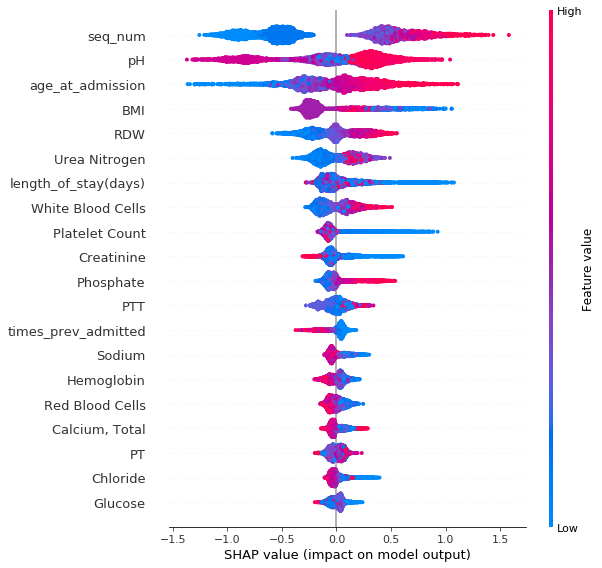

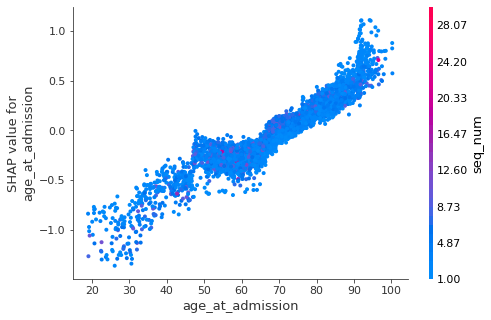

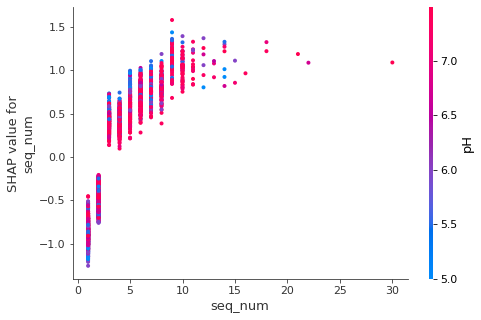

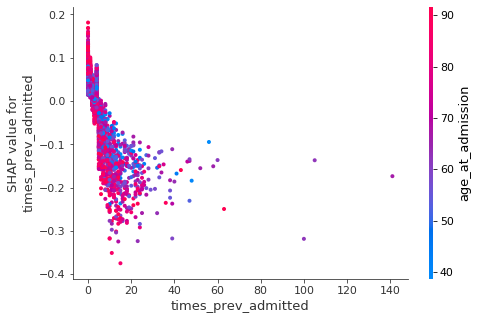

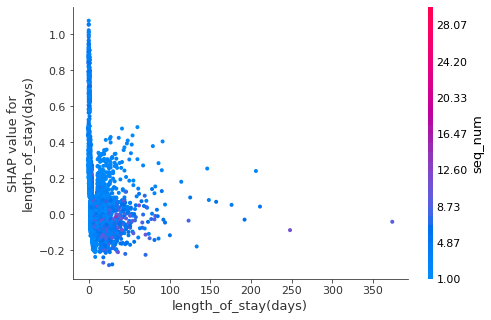

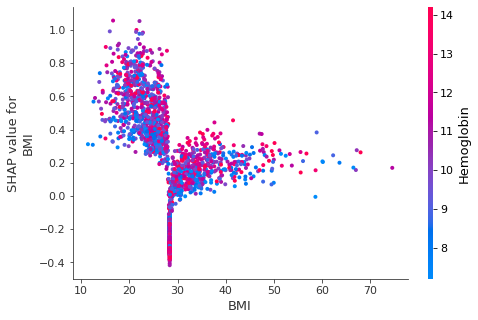

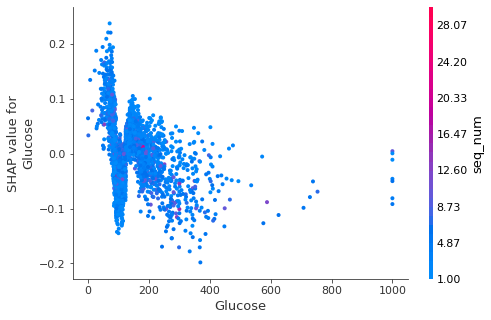

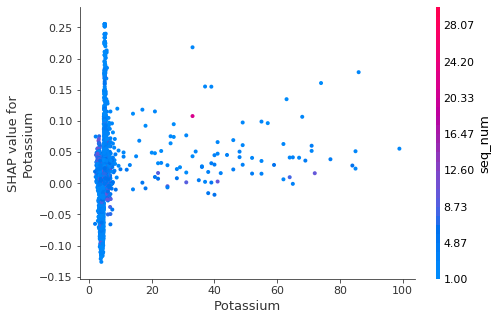

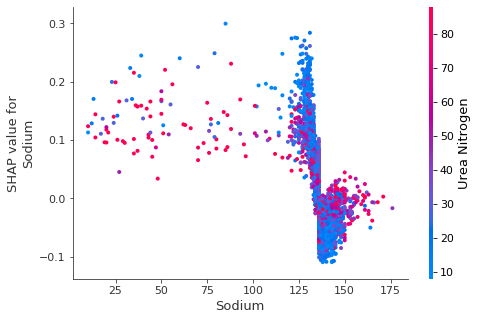

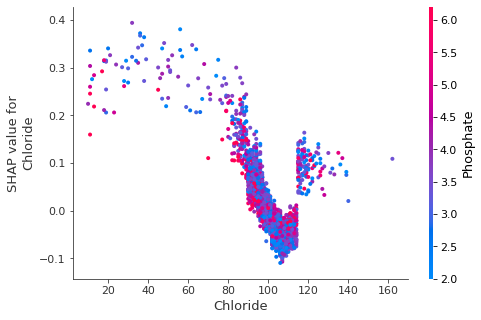

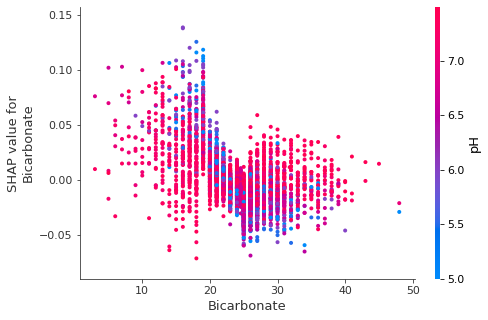

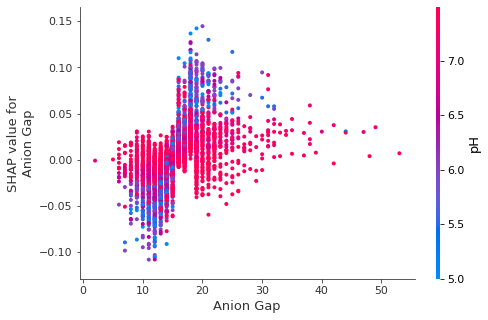

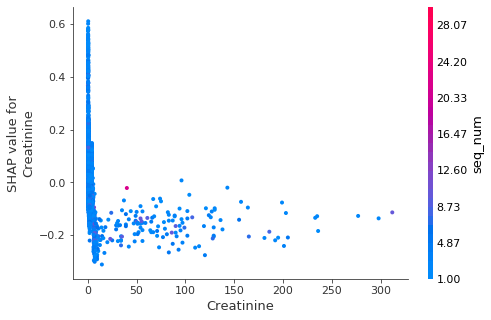

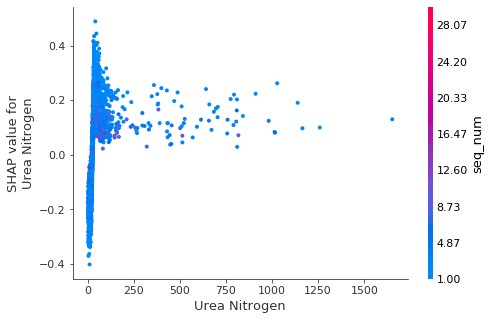

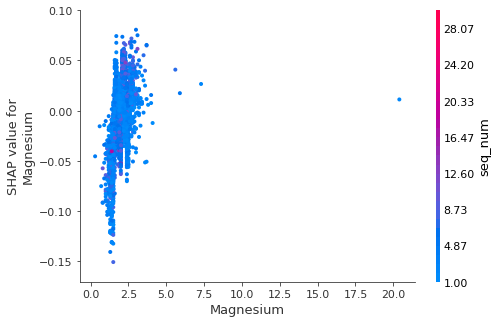

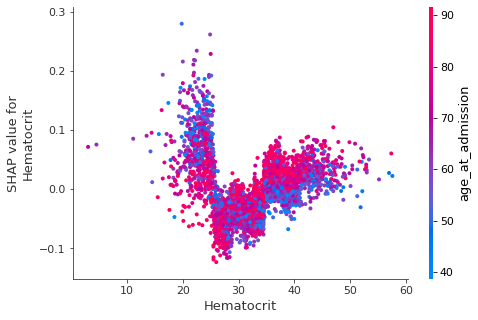

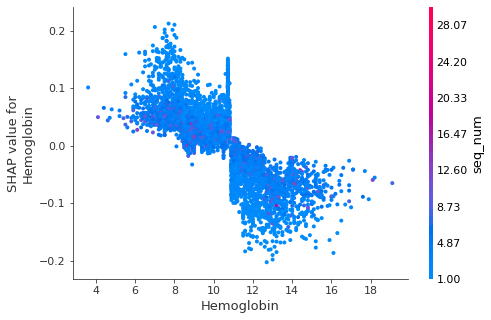

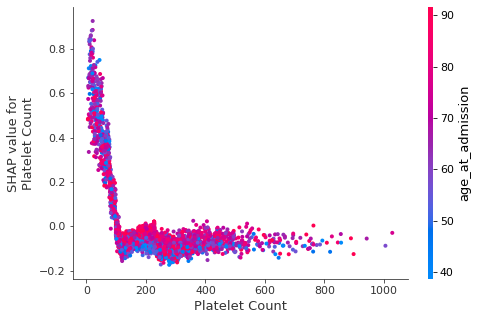

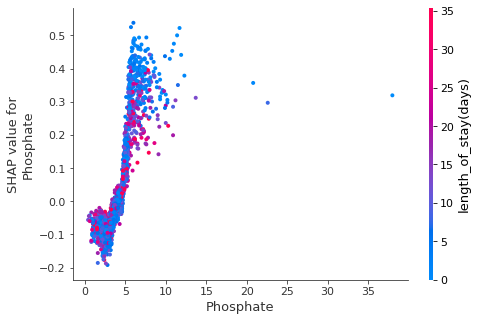

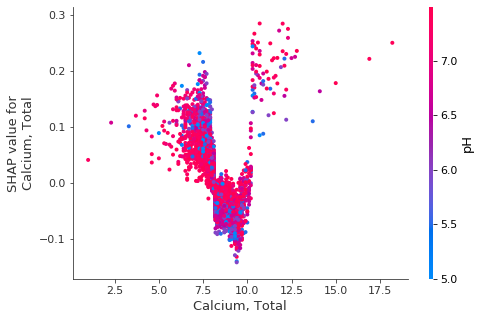

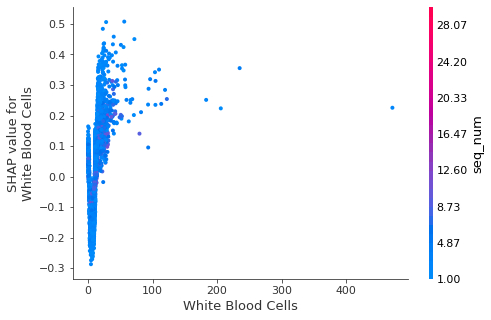

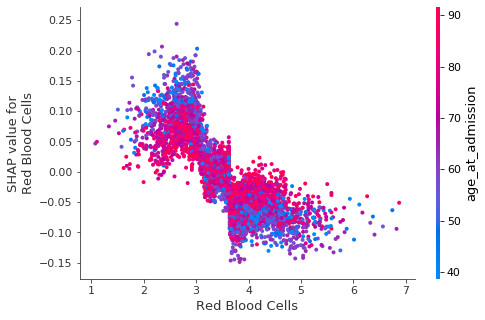

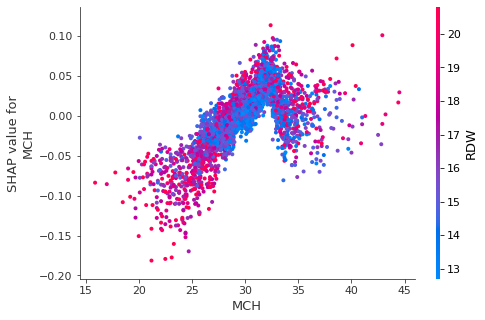

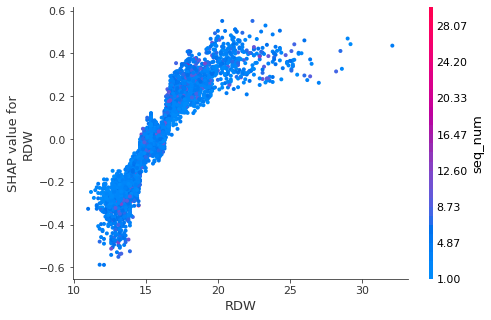

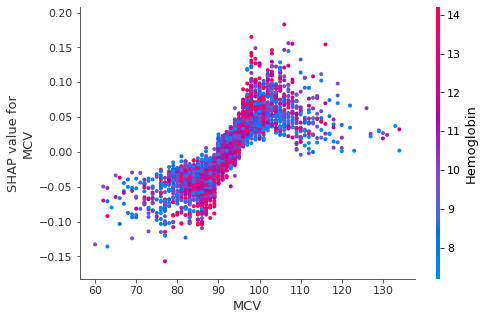

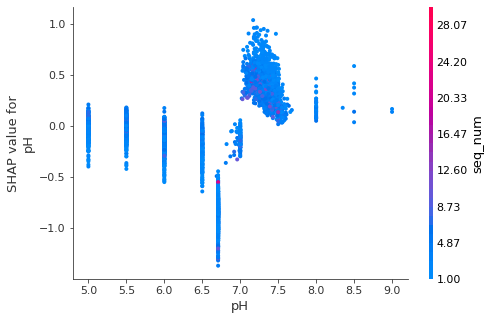

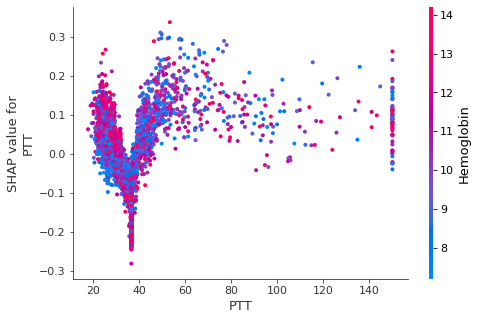

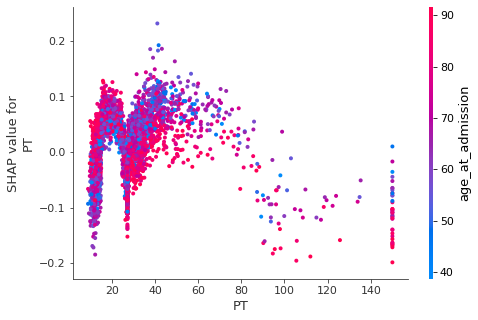

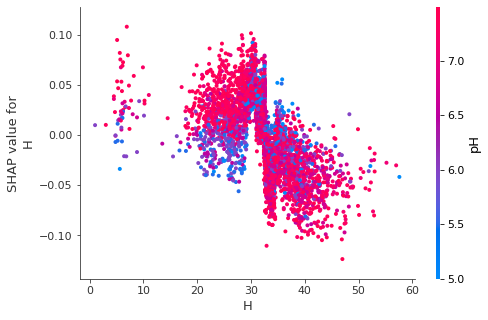

In [8]:
shap_values = explainer.shap_values( X_no_cat)
shap.summary_plot(shap_values,X_no_cat ,feature_names=feature_names)
for predictor in feature_names:
    if predictor not in cat_feature_names:
        shap.dependence_plot(predictor, shap_values,X_no_cat ,feature_names=feature_names)

# CatBoost

In [9]:
CB_classifier = CatBoostClassifier(
     cat_features=cat_features_indices,
     verbose=False,
     early_stopping_rounds=50,
)
CB_params = {
        'learning_rate': [0.05, 0.1],
        'depth': [4,5,6,7,8,9],
        'l2_leaf_reg': [1, 3, 5, 7, 8],
        'scale_pos_weight':  [0.5,0.75,0.9,1, 1.1, 1.25,1.5]

} 
# Note Attention: (ignore, affects speed(not result quality))
# Do not use one-hot encoding during preprocessing. This affects both the training speed and the resulting quality.
model = strat_cv_it(CB_classifier ,CB_params,True,25)
explainer = shap.TreeExplainer(model)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:  9.2min finished


0.8399018979163362

{'scale_pos_weight': 0.75, 'learning_rate': 0.05, 'l2_leaf_reg': 5, 'depth': 7}

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       18.438341      2.386259         0.176860        0.035629   
1       37.972418      1.638871         0.173536        0.024470   
2       19.906414      0.409234         0.216421        0.048066   
3       77.271619      0.162097         0.254984        0.024663   
4       69.090172      5.633537         0.191821        0.051722   
5       14.803066      0.474529         0.181514        0.033328   
6       14.510183      0.226473         0.214427        0.032050   
7       13.160128      1.579684         0.156581        0.040610   
8        8.511231      0.085689         0.145278        0.020183   
9       11.216328      0.332368         0.127658        0.036816   
10      11.322045      0.219898         0.140956        0.022468   
11      13.028480      2.536423         0.160571        0.035271   
12      71.412294      0.625304         0.139294        0.024079   
13      16.426390      0.157444         0.226062        0.054786   
14      44.780871      0.210980         0.156582        0.062824   
15      69.793957      0.771646         0.190822        0.054165   
16      12.681409      0.548449         0.206115        0.021795   
17      28.078552      1.318390         0.159241        0.058502   
18      17.584625      0.550434         0.205450        0.044445   
19      25.073923      0.445684         0.165889        0.030862   
20      18.183357      0.446406         0.199466        0.062829   
21      26.290003      1.728159         0.197472        0.013331   
22      42.028234      0.332538         0.162898        0.019985   
23      23.501463      3.348507         0.096742        0.018353   
24       8.649527      1.572257         0.112367        0.058366   

   param_scale_pos_weight param_learning_rate param_l2_leaf_reg param_depth  \
0                    1.25                0.05                 1           6   
1                    1.25                 0.1                 7           8   
2                     0.5                 0.1                 5           6   
3                    1.25                0.05                 3           9   
4                       1                 0.1                 8           9   
5                       1                0.05                 1           5   
6                     1.5                0.05                 8           5   
7                     1.1                 0.1                 8           5   
8                     0.9                0.05                 5           4   
9                     0.9                0.05                 1           5   
10                    0.5                0.05                 1           5   
11                      1                 0.1                 3           5   
12                    1.1                0.05                 3           9   
13                    1.5                0.05                 3           5   
14                    1.1                0.05                 7           8   
15                    1.5                0.05                 8           9   
16                    0.9                 0.1                 1           4   
17                    0.9                 0.1                 5           7   
18                    0.5                0.05                 8           6   
19                    0.5                 0.1                 3           7   
20                      1                 0.1                 7           6   
21                   0.75                0.05                 5           7   
22                    1.1                 0.1                 8           8   
23                    1.1                0.05                 3           7   
24                    1.5                 0.1                 7           4   

                                               params  split0_test_score  \
0   {'scale_pos_weight': 1.25, 'learning_rate': 0....           0.831422   
1   {'scale_pos_weight': 1.2

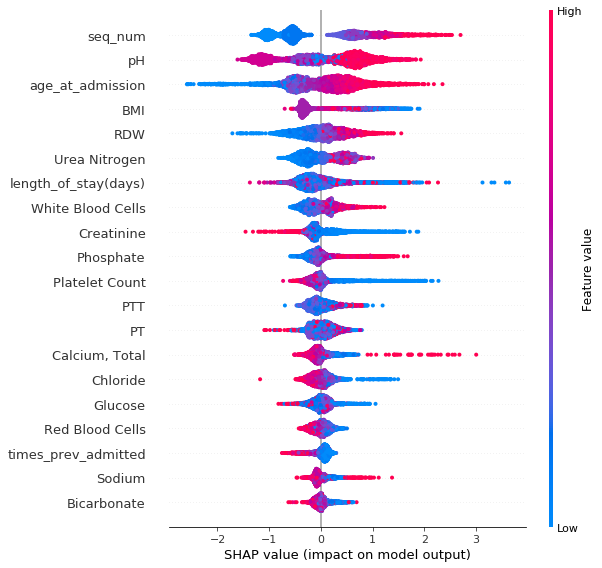

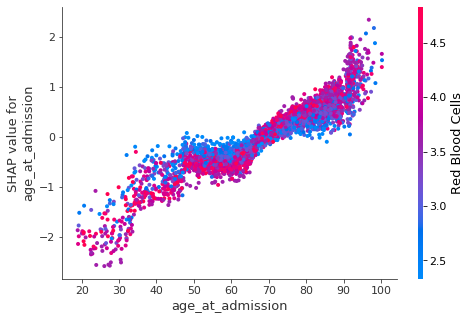

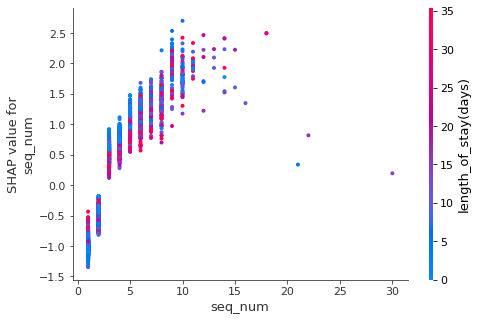

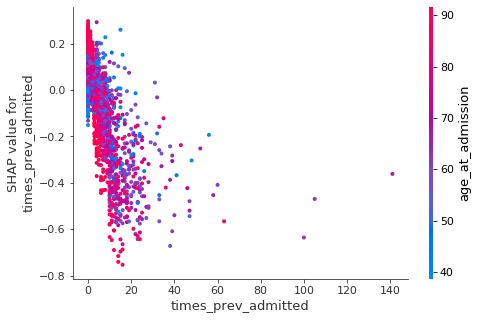

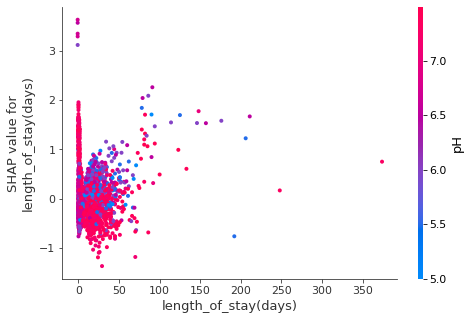

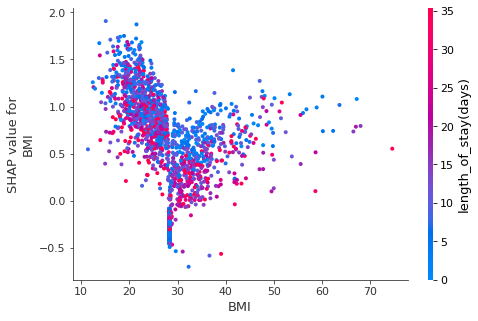

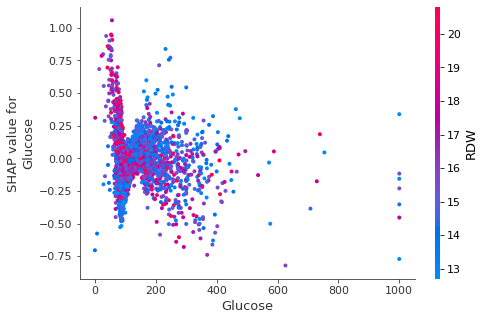

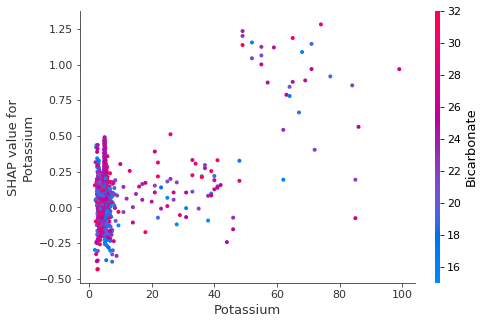

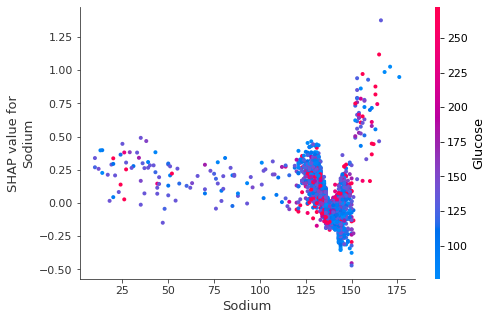

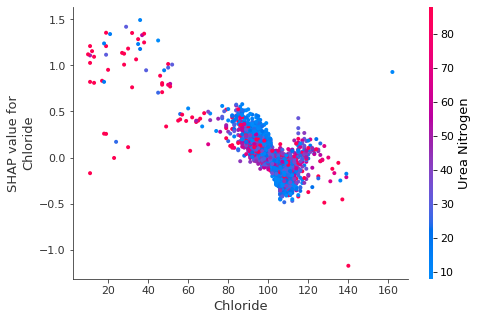

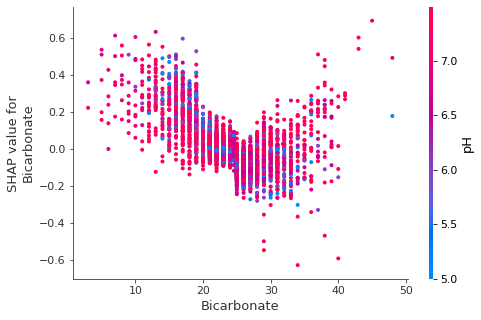

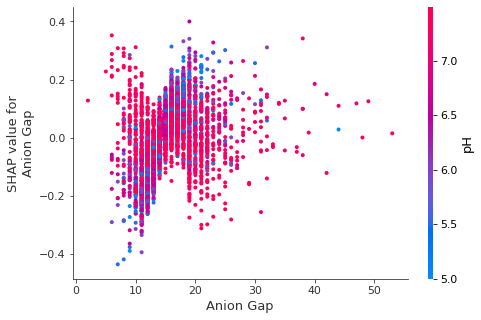

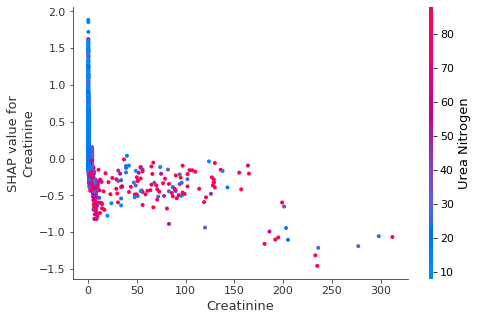

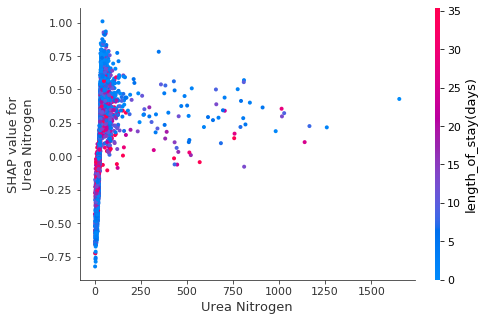

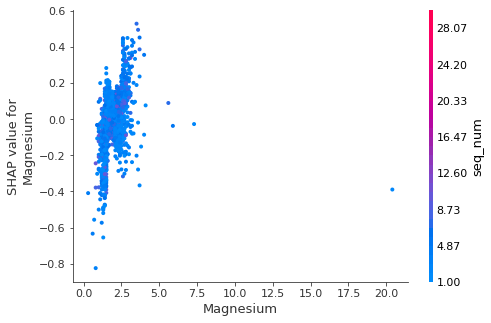

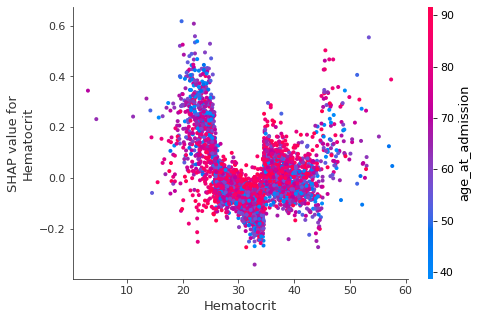

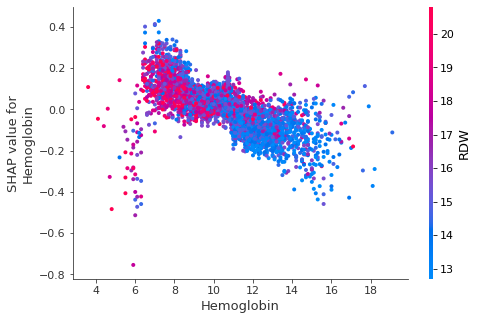

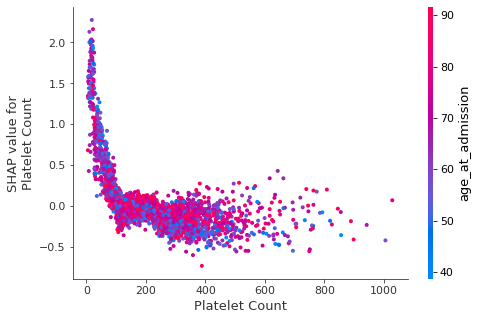

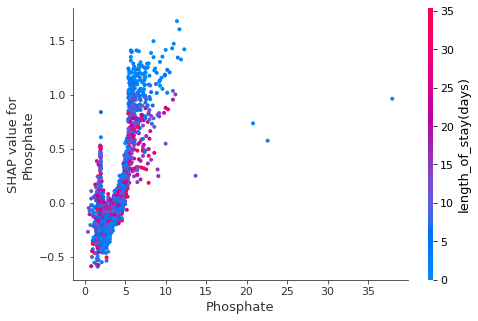

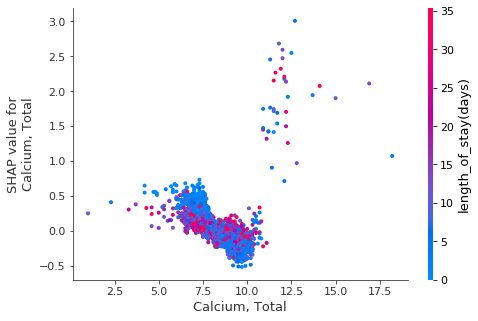

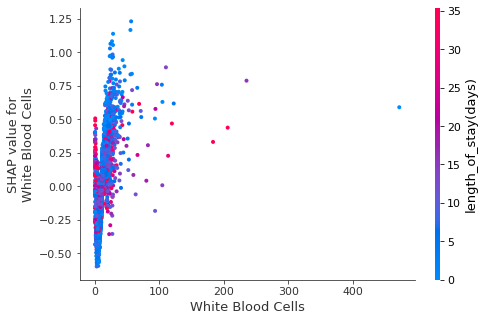

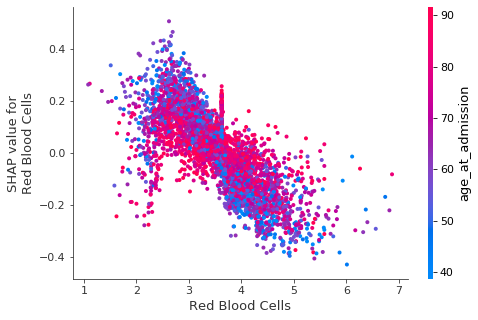

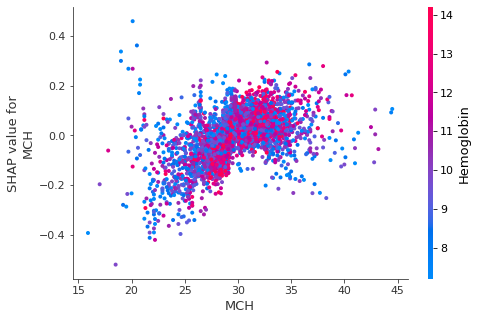

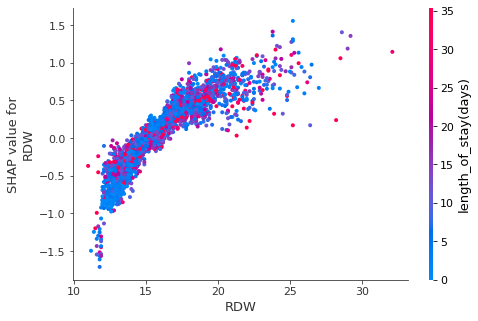

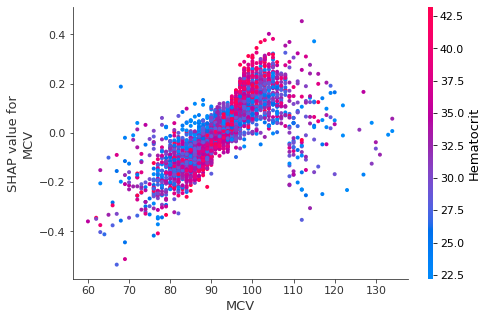

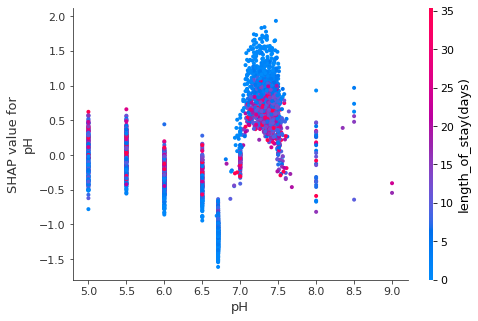

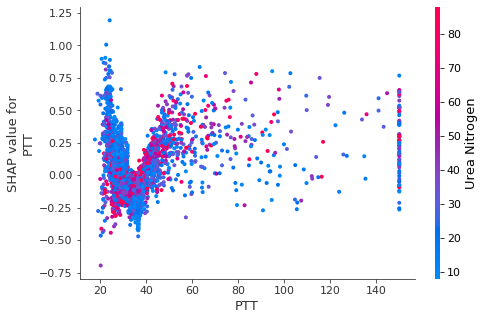

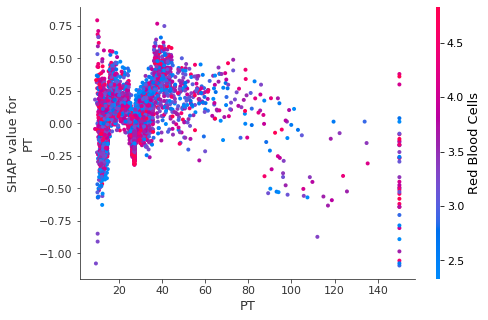

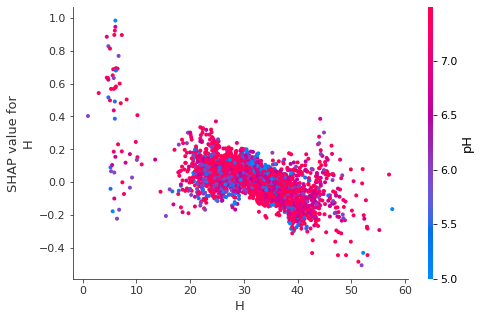

In [10]:
shap_values = explainer.shap_values(dataset_no_target)
shap.summary_plot(shap_values, dataset_no_target ,feature_names=feature_names)
for predictor in feature_names:
    if predictor not in cat_feature_names:
        shap.dependence_plot(predictor, shap_values ,dataset_no_target ,feature_names=feature_names)

# LightGBM

In [11]:
LGB_classifier = lgb.LGBMClassifier()
LGB_params = {
             'num_leaves': [1,5,8,10,15,20,35,40], 
             'min_child_samples': [1,5,10,20,50,100,200,300,400,500], 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': [0.2,0,4,0.5, 0.6, 0.8, 1.0],
             'colsample_bytree': [0.6, 0.8, 1.0],
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'scale_pos_weight':  [0.5,0.75,0.9,1, 1.1, 1.25,1.5]

}
model = strat_cv_it(LGB_classifier ,LGB_params,True,50)
explainer = shap.TreeExplainer(model)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   28.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   35.3s finished


0.8375878744275456

{'subsample': 1.0,
 'scale_pos_weight': 1,
 'reg_lambda': 0.1,
 'reg_alpha': 10,
 'num_leaves': 15,
 'min_child_weight': 0.01,
 'min_child_samples': 100,
 'colsample_bytree': 1.0}

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.068479  2.492732e-03         0.010306        0.000940   
1        0.083782  8.224905e-04         0.013950        0.002164   
2        0.126342  1.242597e-03         0.014289        0.000461   
3        0.021599  4.695888e-04         0.000000        0.000000   
4        0.058855  8.159017e-04         0.010957        0.000806   
5        0.039893  8.142961e-04         0.006665        0.000482   
6        0.062839  8.057465e-04         0.011303        0.000470   
7        0.020944  4.899036e-07         0.000000        0.000000   
8        0.035232  4.604883e-04         0.006658        0.000458   
9        0.073796  9.613917e-06         0.011636        0.000470   
10       0.082778  1.410515e-03         0.014295        0.000470   
11       0.021268  4.768256e-04         0.000000        0.000000   
12       0.021931  8.065097e-04         0.000000        0.000000   
13       0.039228  4.703589e-04         0.006636        0.000461   
14       0.020930  8.144555e-04         0.000000        0.000000   
15       0.020940  8.144208e-04         0.000000        0.000000   
16       0.021277  4.705277e-04         0.000000        0.000000   
17       0.077451  4.829459e-04         0.012314        0.000460   
18       0.020607  4.668515e-04         0.000000        0.000000   
19       0.039567  4.753199e-04         0.006325        0.000464   
20       0.062172  4.809337e-04         0.010624        0.000474   
21       0.049188  4.660654e-04         0.008643        0.000470   
22       0.043224  4.800259e-04         0.006316        0.000470   
23       0.036569  4.697407e-04         0.006651        0.000471   
24       0.039901  8.148355e-04         0.006649        0.000470   
25       0.078139  4.756604e-04         0.011289        0.000480   
26       0.020944  2.247832e-07         0.000000        0.000000   
27       0.020604  4.793784e-04         0.000000        0.000000   
28       0.227057  8.028456e-03         0.017286        0.000943   
29       0.021267  4.767730e-04         0.000000        0.000000   
30       0.021602  9.302652e-04         0.000000        0.000000   
31       0.110032  9.354693e-04         0.014295        0.000484   
32       0.021606  9.417350e-04         0.000000        0.000000   
33       0.218083  1.880649e-03         0.017288        0.000470   
34       0.020944  8.145881e-04         0.000000        0.000000   
35       0.021266  4.781808e-04         0.000000        0.000000   
36       0.021595  9.360953e-04         0.000000        0.000000   
37       0.050857  8.241471e-04         0.008643        0.001244   
38       0.078118  1.235346e-03         0.011303        0.000470   
39       0.020595  4.598601e-04         0.000000        0.000000   
40       0.062479  1.695778e-03         0.009325        0.000478   
41       0.020938  8.059379e-04         0.000000        0.000000   
42       0.062832  8.142961e-04         0.010306        0.000470   
43       0.062832  2.973602e-07         0.011304        0.000470   
44       0.070494  4.668470e-04         0.011952        0.000011   
45       0.021933  1.404654e-03         0.000000        0.000000   
46       0.022266  4.647484e-04         0.000000        0.000000   
47       0.069811  3.878732e-06         0.011303        0.000470   
48       0.020279  4.705275e-04         0.000000        0.000000   
49       0.064154  1.247315e-03         0.010648        0.000457   

   param_subsample param_scale_pos_weight param_reg_lambda param_reg_alpha  \
0              0.2                    0.5               50              50   
1              0.8                    0.5               50               5   
2                1                      1              0.1              10   
3                1                    0.9               50              10   
4              0.5                   1.25              0.1              50   
5                1                    0.9                0         

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


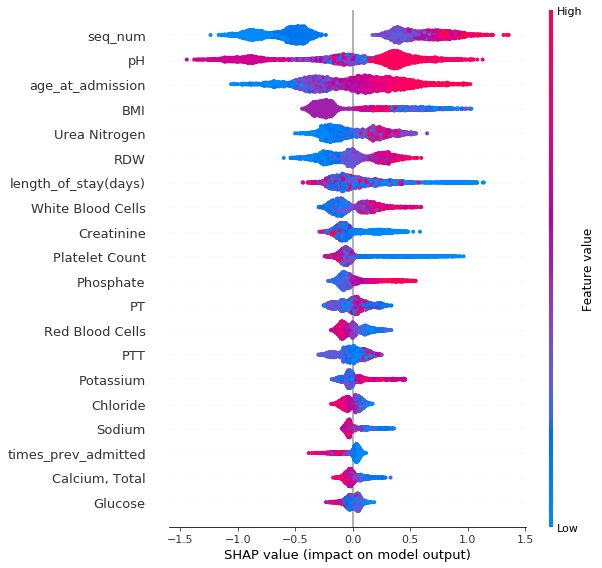

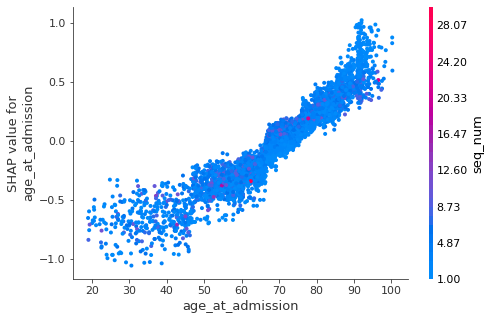

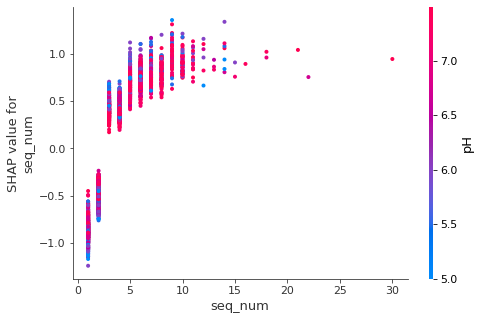

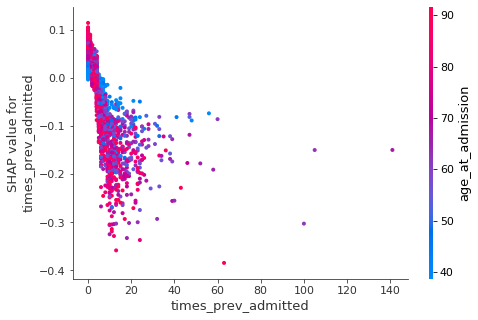

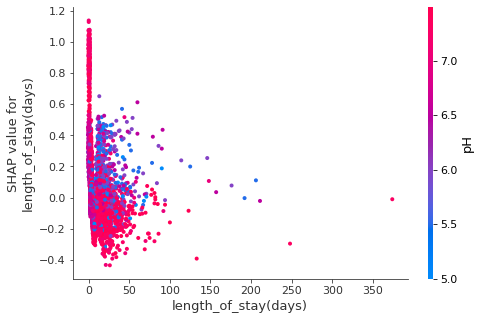

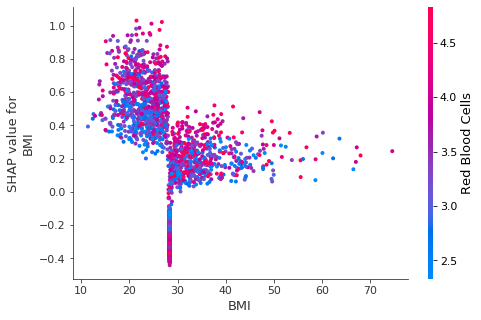

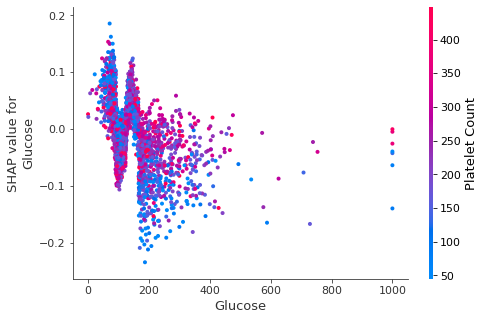

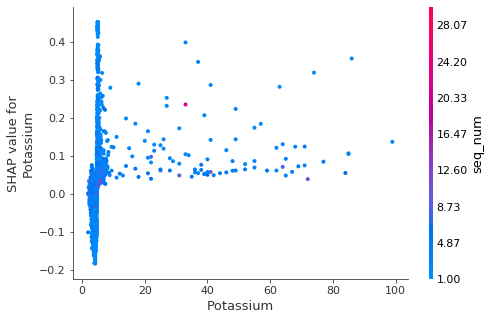

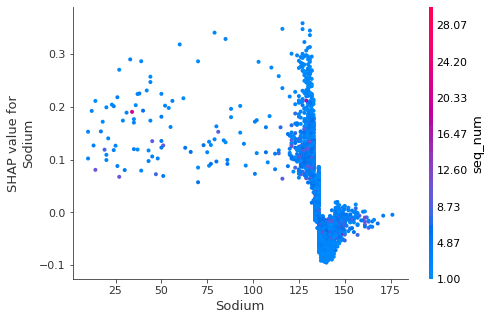

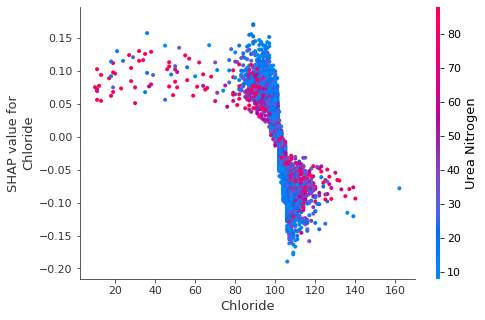

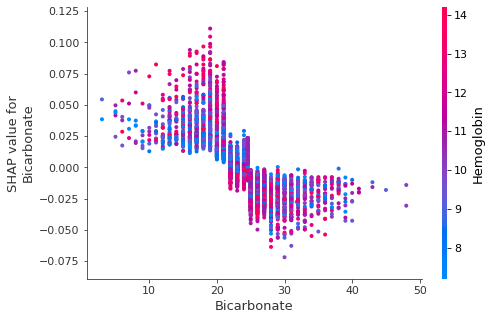

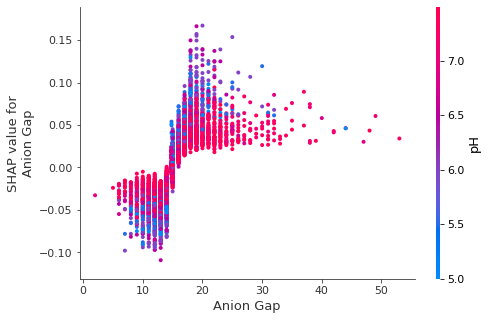

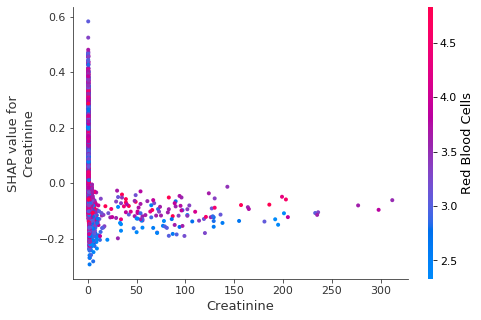

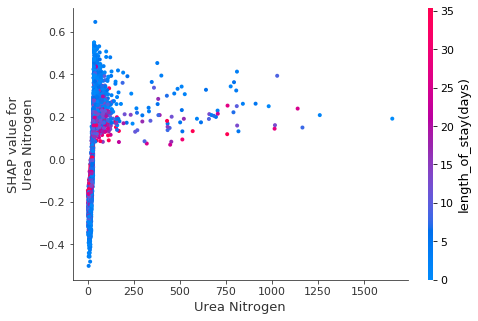

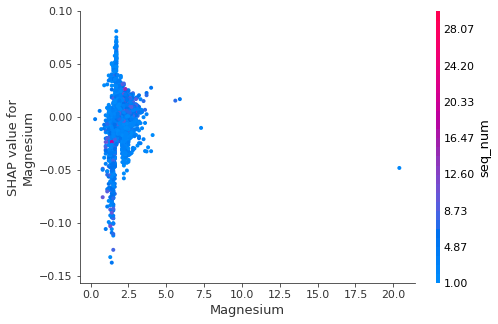

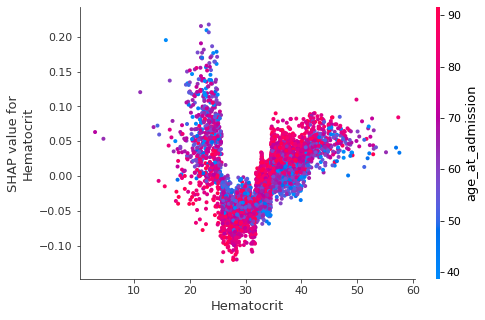

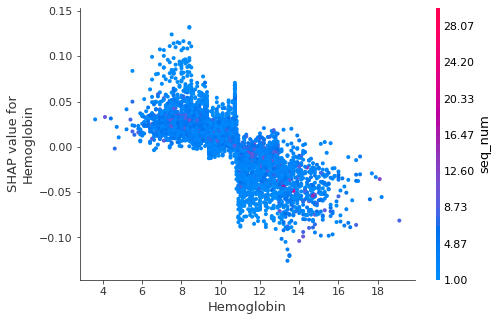

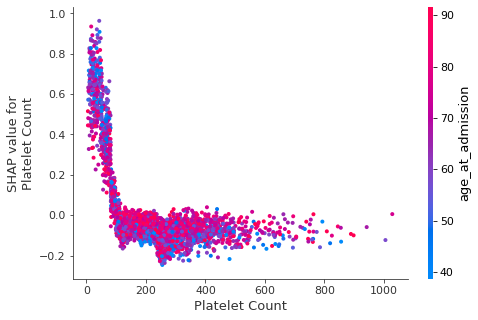

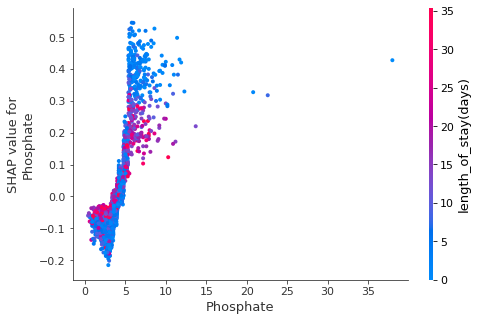

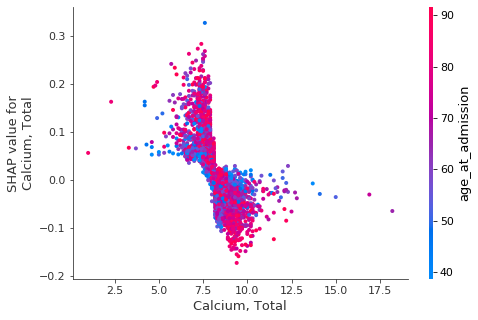

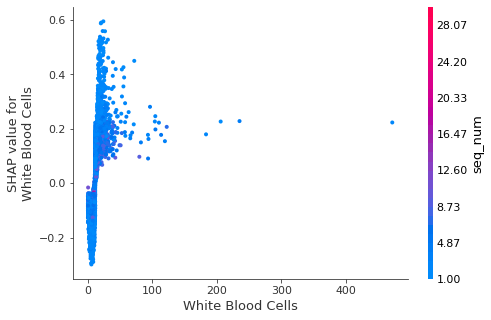

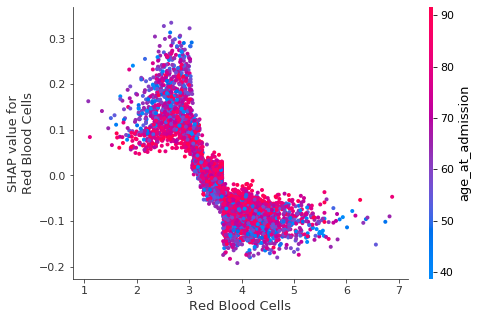

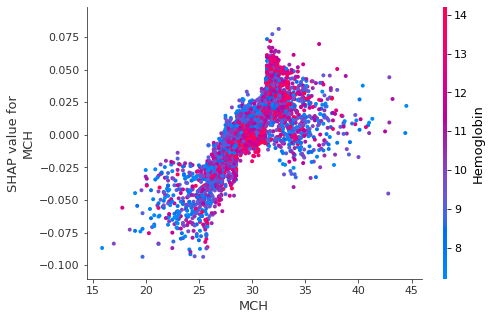

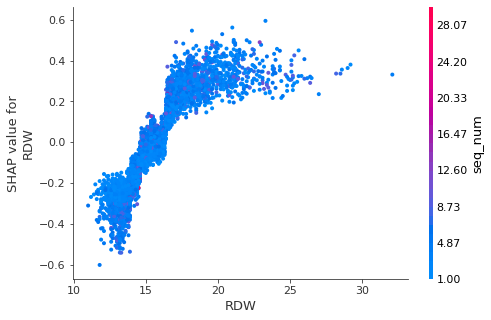

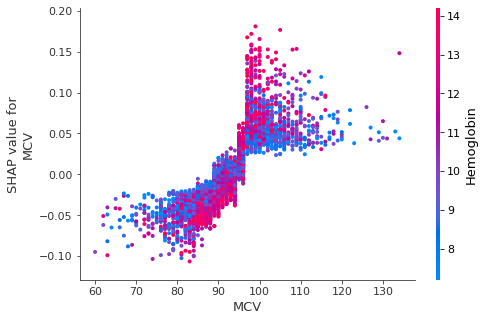

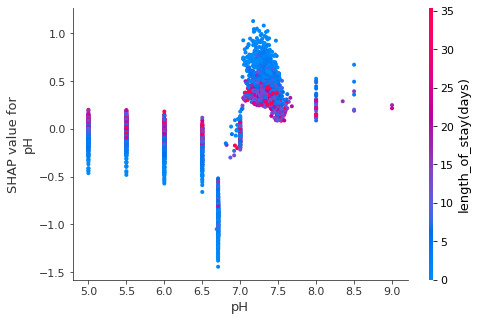

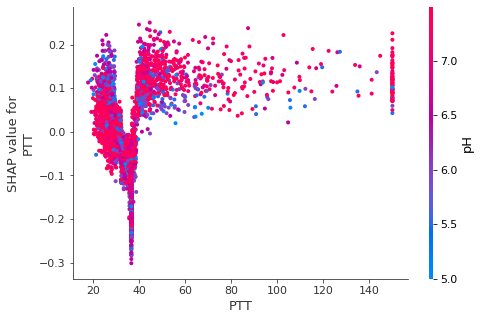

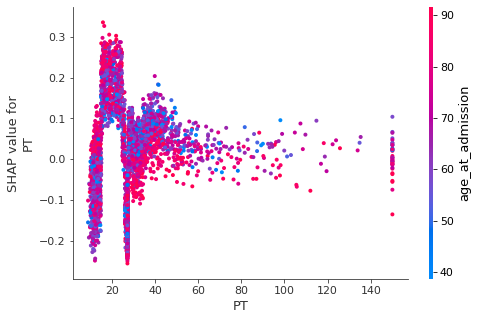

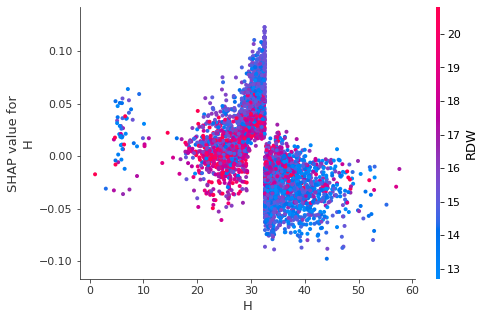

In [12]:
shap_values = explainer.shap_values(dataset_no_target)
shap.summary_plot(shap_values[1], dataset_no_target ,feature_names=feature_names)
for predictor in feature_names:
    if predictor not in cat_feature_names:
        shap.dependence_plot(predictor, shap_values[1] ,dataset_no_target ,feature_names=feature_names)